This Jupyter Notebook file will be our central location for Jyutping Analysis. The analysis in this notebook will help facilitate the planning of HKIME.

## Jyutping Dictionary Initialization

In [3]:
from matplotlib import pyplot as plt
from jyutping_dict import JyutpingDict
import numpy as np

In [4]:
jd = JyutpingDict()

Dictionary of 701 Jyutpings mapping to 38643 different Chinese characters created


## Statistics

In [5]:
print("Prefix Frequencies")
print(jd.prefix_freq)
print("Suffix Frequencies")
print(jd.suffix_freq)
print("2-gram Frequencies")
print(jd.twoGram_freq)

Prefix Frequencies
{'j': 3386, 'd': 1571, 'c': 2721, 'z': 3377, 'k': 1594, 'n': 1946, 'm': 1579, 'g': 3205, 's': 2827, 't': 1360, 'l': 3130, 'h': 2188, 'f': 1372, 'a': 736, 'p': 984, 'w': 1425, 'b': 1393, 'o': 363, 'e': 7, 'u': 15, 'i': 6}
Suffix Frequencies
{'u': 5720, 't': 2287, 'm': 2094, 'a': 901, 'g': 5555, 'i': 7049, 'p': 1245, 'n': 5714, 'o': 904, 'k': 3425, 'e': 291}
2-gram Frequencies
{'ja': 680, 'au': 2115, 'do': 298, 'ou': 1358, 'ca': 851, 'at': 1050, 'zi': 1043, 'im': 631, 'kw': 370, 'wa': 1474, 'aa': 5003, 'ng': 6684, 'ji': 1407, 'ga': 1618, 'ap': 772, 'di': 365, 'in': 2597, 'si': 850, 'to': 395, 'za': 1020, 'ma': 601, 'an': 3160, 'no': 128, 'lo': 625, 'du': 150, 'un': 2713, 'iu': 1010, 'ho': 515, 'ha': 858, 'ki': 200, 'it': 547, 'ai': 2390, 'da': 568, 'sa': 792, 'ke': 290, 'eo': 1821, 'oi': 1676, 'ei': 1263, 'fe': 70, 'jy': 720, 'yu': 1872, 'fa': 583, 'fu': 539, 'co': 448, 'ge': 299, 'ze': 404, 'hu': 148, 'la': 852, 'am': 1390, 'so': 325, 'oe': 929, 'en': 761, 'ju': 271, 

In the following graph, it is very clear which letters are more likely to be prefixes and which are more likely to be suffixes. So, this could be a potentially simple way to dissect Jyutping strings.

Text(0.5, 1.0, 'Suffix Frequencies')

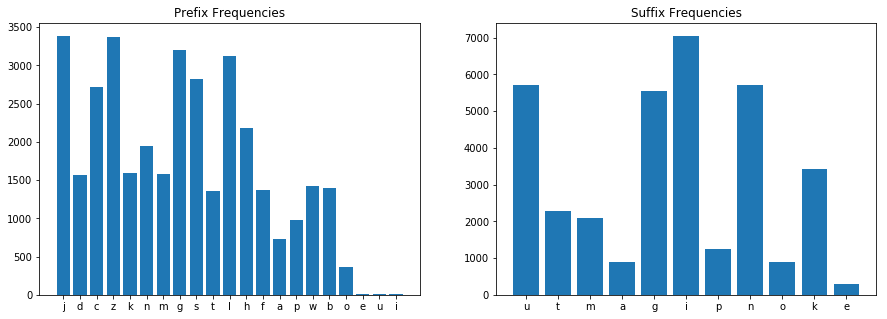

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].bar(jd.prefix_freq.keys(), jd.prefix_freq.values())
ax[0].set_title("Prefix Frequencies")
ax[1].bar(jd.suffix_freq.keys(), jd.suffix_freq.values())
ax[1].set_title("Suffix Frequencies")

## Splitting Jyutping Boundaries

An intelligent IME should be able to determine the boundaries of the individual Jyutpings for each character.
For example, we wish to split "Jyutping (粤拼)" into ["jyut (粤)", "ping (拼)"].

### Goals:
- Seperate Fuzzy Jyutping (模糊拼音 in regular pinyin IME's)
- Seperate Incomplete Jyutping ("dg" -> "點解")

### Problem Statement
For a given input Jyutping string corresponding to two words $S$, define the event $s_i$ as being $S[i]$ is the last character of the Jyutping corresponding to the first word and $S[i + 1]$ is the first character for the next word. Thus, the problem can be expressed as finding $\max_{i} \mathbb{P}(s_i)$.



### Head and Tail 2-gram Approach
In the following, we will define $g_k$ as the 2-gram $S[k: k + 2]$. We will also let $H(g_k)$ and $T(g_k)$ denote the events that $g_k$ is a head 2-gram and a tail 2-gram respectively. 

It is reasonable to assume that $H$ and $T$ are independent. We will also make the assumption that $$\max_{i} \mathbb{P}(s_i) = \max_i \mathbb{P}(g_{i - 1} \text{is a tail 2-gram} \cap g_{i + 1}
\text{is a head 2-gram}),$$
which we can simplify with our independence assumption to
$$\max_i \mathbb{P}(s_i) = \max_i \mathbb{P}(T(g_{i-1}) \cap H(g_{i+1})) = \max_i \mathbb{P}(T(g_{i-1}))\mathbb{P}(H(g_{i+1})).$$

In [7]:
def ht2gram_split(jyutdict, jyutping_input):
    # TODO: Edge cases for short inputs causing index OOB
    # and case that no valid split could be found
    
    def get_2gram(g_k):
        return jyutping_input[g_k : min(g_k + 2, len(jyutping_input))]
    
    def calculate_prob(s_i):
        head_p = jyutdict.calc_twoGramTail_prob(get_2gram(s_i - 1))
        tail_p = jyutdict.calc_twoGramHead_prob(get_2gram(s_i + 1))
        return head_p * tail_p
    
    idxs = len(jyutping_input) - 1
    probs = [calculate_prob(i) for i in range(idxs)]
    max_i = max(range(idxs), key=calculate_prob)
        
    return jyutping_input[:max_i + 1], jyutping_input[max_i + 1:]

In [8]:
# 粵拼、一點、丁丁、叉燒
jyutping_list = ["jyutping", "jatdim", "dingding", "caasiu"]
for j_input in jyutping_list:
    first, second = ht2gram_split(jd, j_input)
    print(first, second)

jyut ping
jat dim
ding ding
caa siu


In [14]:
# Accuracy testing with fuzzer input, may not create valid words
jyutping_list = list(jd.jyutdict.keys())
num_jyutping = len(jyutping_list)
def generate_random_pair():
    a = np.random.randint(0, num_jyutping)
    b = np.random.randint(0, num_jyutping)
    return (jyutping_list[a] + jyutping_list[b],
            jyutping_list[a],
            jyutping_list[b])

def generate_fuzz(count):
    return [generate_random_pair() for i in range(count)]


In [10]:
fuzz = generate_fuzz(5000)

In [12]:
accuracy_count = 0
for j in fuzz:
    jyutping_input = j[0]
    first, second = ht2gram_split(jd, jyutping_input)
    if first == j[1] and second == j[2]:
        accuracy_count += 1
    else:
        print(first, second, j[1], j[2])
print("----------------------------------------")
print(f"Number of accurate segmentations: {accuracy_count}")
print("Number of tests: 5000")
print(f"Percentage correct: {accuracy_count * 100 / 5000}%")

ng aadaan ngaa daan
soeing aau soei ngaau
tun gwong tung wong
gong aa gon gaa
lice ng li ceng
ng aicyu ngai cyu
hmlo ng hm long
makcaa ng mak caang
mije ng mi jeng
nan ge nang e
daa maau daam aau
jole ng jo leng
laa mo laam o
ng aatjyut ngaat jyut
jok am jo kam
ng onhoi ngon hoi
haa ngkuk haang kuk
ng aiming ngai ming
jaan gou jaang ou
caa ngei caan gei
tyunng aan tyun ngaan
joekci ng joek cing
gatgwaa ng gat gwaang
bek ap be kap
zoelaa ng zoe laang
mong aa mo ngaa
ngmci ng ngm cing
on gak ong ak
ninaa ng nin aang
bengu ng be ngung
sun gwik sung wik
gaatbaa ng gaat baang
ng aakaam ngaak aam
naatcaa ng naat caang
paa kaa paak aa
ng aapjat ngaap jat
gwung aam gwu ngaam
ng oudut ngou dut
aaipaa ng aai paang
mikng aam mik ngaam
maan gaap maa ngaap
saa map saam ap
jezo ng je zong
himng aa him ngaa
saan ok saa nok
maa ng m aang
cin gwi cing wi
ditng aam dit ngaam
g oie goi e
ng ouhyun ngou hyun
non aam no naam
heng aam he ngaam
ming aap mi ngaap
kuik wui kui kwui
kukng aap kuk ngaap
lapzaa n

### Head and Tail 2-gram Approach with next-best suggestions 
Here, we modify our `ht2gram_split()` method slightly to instead return a list of candidate splits ranked in order of likelihood. Since we know the entire list of valid Jyutpings (in `JyutpingDict`), we can eliminate splits with $0$ probability. Similarly, we also know that the correct split will have a guaranteed non-zero probability.  This will help negate the inaccuracy of our probabilistic method.

In [13]:
def ht2gram_split_list(jyutdict, jyutping_input):
    # TODO: Edge cases for short inputs causing index OOB
    # and case that no valid split could be found
    
    def get_2gram(g_k):
        return jyutping_input[g_k : min(g_k + 2, len(jyutping_input))]
    
    def calculate_prob(s_i):
        head_p = jyutdict.calc_twoGramTail_prob(get_2gram(s_i - 1))
        tail_p = jyutdict.calc_twoGramHead_prob(get_2gram(s_i + 1))
        return head_p * tail_p
    
    idxs = list(range(len(jyutping_input) - 1))
    probs = [calculate_prob(i) for i in idxs]
    idxs.sort(key=calculate_prob)
    idxs = list(filter(lambda x: x > 0, idx))
    
    def idx_to_split(idx):
        return (jyutping_input[:idx + 1], jyutping_input[max_i + 1])
        
    return [idx_to_split(idx) for idx in idxs]


In [ ]:
accuracy_count = 0
for j in fuzz:
    jyutping_input = j[0]
    candidates = ht2gram_split(jd, jyutping_input)
    print(candidates)
    print((j[1], j[2]))
    print((j[1], j[2]) in candidates)
    if (j[1], j[2]) in candidates:
        accuracy_count += 1
print("----------------------------------------")
print(f"Number of accurate segmentations: {accuracy_count}")
print("Number of tests: 5000")
print(f"Percentage correct: {accuracy_count * 100 / 5000}%")

# TODO
# Python does not seem to recognize 2-tuples with identical strings to be identical
# May have to override method?

('nan', 'coek')
('nan', 'coek')
False
('zoeng', 'bit')
('zoeng', 'bit')
False
('kui', 'hik')
('kui', 'hik')
False
('sei', 'laan')
('sei', 'laan')
False
('jyut', 'zyun')
('jyut', 'zyun')
False
('jin', 'pat')
('jin', 'pat')
False
('waa', 'go')
('waa', 'go')
False
('nap', 'jam')
('nap', 'jam')
False
('leoi', 'lem')
('leoi', 'lem')
False
('lem', 'zyut')
('lem', 'zyut')
False
('gaa', 'din')
('gaa', 'din')
False
('gok', 'gei')
('gok', 'gei')
False
('aat', 'gaat')
('aat', 'gaat')
False
('ging', 'gam')
('ging', 'gam')
False
('sak', 'zim')
('sak', 'zim')
False
('ngaan', 'caak')
('ngaan', 'caak')
False
('bai', 'loe')
('bai', 'loe')
False
('dai', 'tim')
('dai', 'tim')
False
('zit', 'wo')
('zit', 'wo')
False
('gou', 'fai')
('gou', 'fai')
False
('long', 'hai')
('long', 'hai')
False
('zong', 'dyut')
('zong', 'dyut')
False
('deoi', 'jaau')
('deoi', 'jaau')
False
('hoeng', 'leot')
('hoeng', 'leot')
False
('ngit', 'ke')
('ngit', 'ke')
False
('gwik', 'gum')
('gwik', 'gum')
False
('co', 'hoeng')
('co', '

('caang', 'gwit')
('caang', 'gwit')
False
('lou', 'zyut')
('lou', 'zyut')
False
('ngam', 'haan')
('ngam', 'haan')
False
('lat', 'can')
('lat', 'can')
False
('it', 'koi')
('it', 'koi')
False
('gap', 'sip')
('gap', 'sip')
False
('kan', 'seng')
('kan', 'seng')
False
('zaap', 'cyut')
('zaap', 'cyut')
False
('pin', 'ai')
('pin', 'ai')
False
('fo', 'duk')
('fo', 'duk')
False
('cip', 'hat')
('cip', 'hat')
False
('kiu', 'zak')
('kiu', 'zak')
False
('keoi', 'gaang')
('keoi', 'gaang')
False
('gai', 'ne')
('gai', 'ne')
False
('ou', 'laam')
('ou', 'laam')
False
('laau', 'jo')
('laau', 'jo')
False
('ngot', 'ceot')
('ngot', 'ceot')
False
('goeng', 'aau')
('goeng', 'aau')
False
('gukpaa', 'ng')
('guk', 'paang')
False
('hok', 'goeng')
('hok', 'goeng')
False
('soe', 'nung')
('soe', 'nung')
False
('kak', 'faat')
('kak', 'faat')
False
('hau', 'coek')
('hau', 'coek')
False
('gung', 'daam')
('gung', 'daam')
False
('ngo', 'mei')
('ngo', 'mei')
False
('kwaak', 'ng')
('kwaak', 'ng')
False
('m', 'mik')
('m', '

('soe', 'hik')
('soe', 'hik')
False
('suk', 'zai')
('suk', 'zai')
False
('ngamng', 'aa')
('ngam', 'ngaa')
False
('tau', 'waang')
('tau', 'waang')
False
('dek', 'sip')
('dek', 'sip')
False
('gwi', 'lau')
('gwi', 'lau')
False
('leu', 'zyu')
('leu', 'zyu')
False
('cik', 'wui')
('ci', 'kwui')
False
('teoi', 'maak')
('teoi', 'maak')
False
('mam', 'gaai')
('mam', 'gaai')
False
('naai', 'lit')
('naai', 'lit')
False
('buk', 'mai')
('buk', 'mai')
False
('seoi', 'lik')
('seoi', 'lik')
False
('cing', 'ho')
('cing', 'ho')
False
('cyut', 'mut')
('cyut', 'mut')
False
('gu', 'cuk')
('gu', 'cuk')
False
('ne', 'jap')
('ne', 'jap')
False
('lei', 'hak')
('lei', 'hak')
False
('kau', 'saam')
('kau', 'saam')
False
('pat', 'zeoi')
('pat', 'zeoi')
False
('nim', 'gut')
('nim', 'gut')
False
('jip', 'noeng')
('jip', 'noeng')
False
('lai', 'caai')
('lai', 'caai')
False
('tit', 'gwaan')
('tit', 'gwaan')
False
('laai', 'tong')
('laai', 'tong')
False
('dai', 'maak')
('dai', 'maak')
False
('nozo', 'ng')
('no', 'zong'

False
('dai', 'lan')
('dai', 'lan')
False
('faa', 'nguk')
('faan', 'guk')
False
('luk', 'ai')
('luk', 'ai')
False
('ming', 'gau')
('ming', 'gau')
False
('goeng', 'ci')
('goeng', 'ci')
False
('gok', 'ngon')
('gok', 'ngon')
False
('zaa', 'jeoi')
('zaa', 'jeoi')
False
('teoi', 'zaa')
('teoi', 'zaa')
False
('ceon', 'haak')
('ceon', 'haak')
False
('ei', 'zai')
('ei', 'zai')
False
('leoikwaa', 'ng')
('leoi', 'kwaang')
False
('kwang', 'jip')
('kwang', 'jip')
False
('gip', 'lau')
('gip', 'lau')
False
('saak', 'ngot')
('saak', 'ngot')
False
('ngong', 'cyut')
('ngong', 'cyut')
False
('kwaai', 'kwok')
('kwaai', 'kwok')
False
('cam', 'lip')
('cam', 'lip')
False
('jap', 'zit')
('jap', 'zit')
False
('dak', 'gwut')
('dak', 'gwut')
False
('bei', 'laau')
('bei', 'laau')
False
('cok', 'zan')
('cok', 'zan')
False
('nak', 'bo')
('nak', 'bo')
False
('zaan', 'ting')
('zaan', 'ting')
False
('caa', 'jo')
('caa', 'jo')
False
('ng', 'okkau')
('ngok', 'kau')
False
('saai', 'ham')
('saai', 'ham')
False
('fang', '

False
('sung', 'fau')
('sung', 'fau')
False
('pou', 'piu')
('pou', 'piu')
False
('kwan', 'sai')
('kwan', 'sai')
False
('kik', 'fing')
('kik', 'fing')
False
('gwo', 'giu')
('gwo', 'giu')
False
('hip', 'bun')
('hip', 'bun')
False
('hak', 'kung')
('hak', 'kung')
False
('maak', 'loi')
('maak', 'loi')
False
('zong', 'me')
('zong', 'me')
False
('ngm', 'go')
('ngm', 'go')
False
('zeze', 'ng')
('ze', 'zeng')
False
('fuk', 'zyu')
('fuk', 'zyu')
False
('go', 'heoi')
('go', 'heoi')
False
('caam', 'haau')
('caam', 'haau')
False
('baau', 'ne')
('baau', 'ne')
False
('wok', 'aat')
('wo', 'kaat')
False
('cyun', 'wing')
('cyun', 'wing')
False
('noi', 'koi')
('noi', 'koi')
False
('nik', 'wok')
('nik', 'wok')
False
('gut', 'zung')
('gut', 'zung')
False
('hoe', 'jo')
('hoe', 'jo')
False
('bou', 'gwik')
('bou', 'gwik')
False
('bang', 'wang')
('bang', 'wang')
False
('pun', 'po')
('pun', 'po')
False
('bek', 'bing')
('bek', 'bing')
False
('wut', 'ngot')
('wut', 'ngot')
False
('piu', 'ling')
('piu', 'ling')
Fa